<a id='title'/>

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16,10]
import seaborn as sns
sns.set_palette('colorblind')
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
import re
from tensorflow import convert_to_tensor
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [267]:
# Import data
df = pd.read_csv('srl_sentiment_labeled_data.csv')

In [268]:
# Review data shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7673 entries, 0 to 7672
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Review           7673 non-null   object
 1   Label            7673 non-null   object
 2   sentiment        7673 non-null   object
 3   sentiment label  7673 non-null   object
 4   srl label        7673 non-null   object
dtypes: object(5)
memory usage: 299.9+ KB


In [269]:
# Keep relevant columns
df = df[['Review', 'sentiment']]

In [270]:
# Remove observations with no text
df = df.dropna(subset='Review')

In [271]:
# Review data shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7673 entries, 0 to 7672
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     7673 non-null   object
 1   sentiment  7673 non-null   object
dtypes: object(2)
memory usage: 120.0+ KB


In [272]:
# Remove numbers from text
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

df['Review'] = df['Review'].apply(remove_numbers)

In [273]:
# Define function to identify unusual characters
def has_unusual_chars(text):
    # usual characters to ignore
    if re.search(r'[^\w\s,.;:!?\-]', text):
        return True
    else:
        return False

In [274]:
# Create new column to identify observations with unusual characters
df['unusual_chars'] = df['Review'].apply(has_unusual_chars)

In [275]:
# View identified characters
df[df['unusual_chars'] == True]

,Review,sentiment,unusual_chars
3,leaving aa's behind at a lower price than the ...,POSITIVE,True
12,with the current $ rebate its about the same p...,POSITIVE,True
19,we paid around $ pair- about the same price w...,NEGATIVE,True
23,so $ for the unit and then another $ to get ...,NEGATIVE,True
29,as a smaller sized set it's great for the bed...,POSITIVE,True
...,...,...,...
7663,otherwise it's awesome the sound is as good a...,POSITIVE,True
7664,otherwise it's awesome the sound is as good a...,POSITIVE,True
7665,its faster than the scroll wheel on garmin i ...,POSITIVE,True
7667,this unit is better than any usb headset i hav...,POSITIVE,True


In [276]:
# Quantify observations found
print(f'Percent of Observation with Unusual Characters: {round(df.unusual_chars.mean() * 100, 2)}%')

Percent of Observation with Unusual Characters: 27.47%


In [277]:
# Initialize a Tokenizer object
tokenizer = Tokenizer(num_words=10000)

In [278]:
# Fit the tokenizer on the text data
tokenizer.fit_on_texts(df['Review'])

In [279]:
# Convert texts into sequences of integers and tokens
df['sequence'] = tokenizer.texts_to_sequences(df['Review'])
df['seq_text'] = tokenizer.sequences_to_texts(df['sequence'])

In [280]:
df['sequence'] 

0       [186, 75, 214, 24, 139, 27, 97, 3074, 130, 410...
1       [5, 357, 1, 358, 19, 11, 1142, 2, 65, 9, 112, ...
2       [169, 1700, 131, 2, 972, 1302, 12, 1, 21, 13, ...
3       [2516, 2517, 3075, 29, 2, 73, 13, 7, 1, 2518, ...
4       [11, 98, 96, 1143, 3, 5, 178, 8, 12, 2, 18, 17...
                              ...                        
7668    [81, 265, 31, 16, 36, 16, 22, 164, 1166, 265, ...
7669    [46, 31, 17, 7, 370, 121, 265, 4100, 15, 33, 1...
7670    [1, 990, 28, 197, 188, 265, 45, 31, 114, 6, 92...
7671    [5, 351, 19, 20, 6, 18, 6, 300, 12, 38, 229, 4...
7672    [1, 232, 4, 17, 7, 22, 125, 68, 2460, 158, 144...
Name: sequence, Length: 7673, dtype: object

In [281]:
df['seq_text']

0       while there may have been less noise caused by...
1       i love the fact that this adds a little more w...
2       go ahead find a center channel for the same pr...
3       leaving aa's behind at a lower price than the ...
4       this product works wonderful and i got it for ...
                              ...                        
7668    these speakers are as good as my bose outdoor ...
7669    they are better than regular computer speakers...
7670    the package has two small speakers which are s...
7671    i thought that was to much to pay for one ink ...
7672    the remote is better than my old sony hi thoug...
Name: seq_text, Length: 7673, dtype: object

In [282]:
# Count the word index
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

Found 7603 unique tokens.


In [283]:
# Calculate sequence lengths
df['seq_length'] = df['sequence'].apply(len)
df.drop('sequence', axis=1, inplace=True)

In [284]:
# Print summary statistics
print(df['seq_length'].describe())

count    7673.000000
mean       19.805682
std         5.901115
min         4.000000
25%        15.000000
50%        20.000000
75%        24.000000
max        33.000000
Name: seq_length, dtype: float64


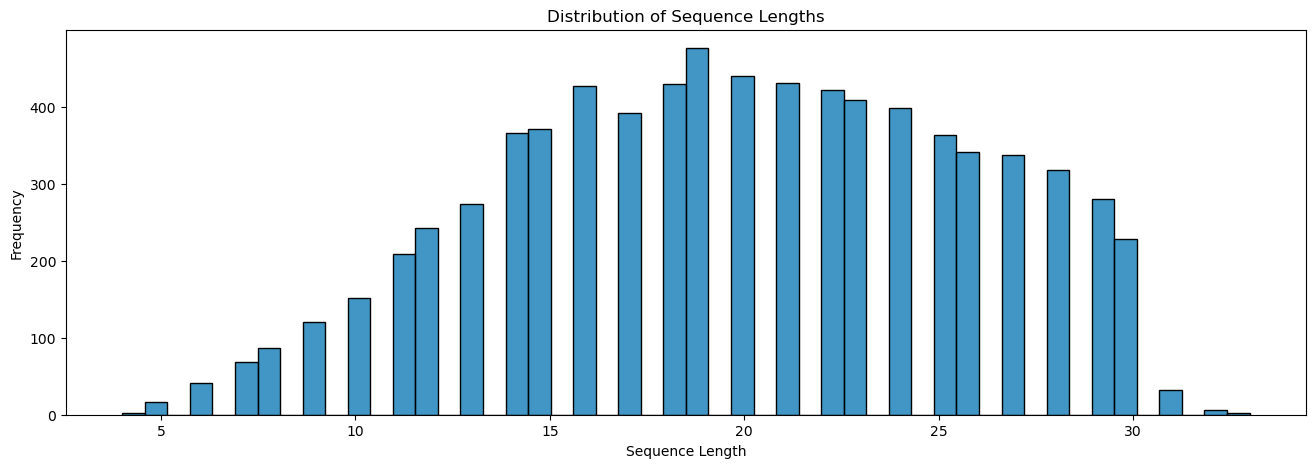

In [285]:
plt.rcParams['figure.figsize'] = [16,5]
# Visualize distribution of sequence lengths
sns.histplot(data=df['seq_length'], bins=50)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()
plt.rcParams['figure.figsize'] = [16,10]

In [286]:
# Identify the 95th percentile of sequence lengths
max_seq = int(df.seq_length.quantile(0.95))
print(f'Chosen Maximum Sequence Length: {max_seq} tokens')

Chosen Maximum Sequence Length: 29 tokens


In [287]:
# Tokenize text sequence
df['tokens'] = df['seq_text'].apply(word_tokenize)

In [288]:
# Initialize a WordNetLemmatizer object
lemmatizer = WordNetLemmatizer()

In [289]:
# Define a function to lemmatize tokens
def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

In [290]:
# Convert words into their root forms
df['lemmatized'] = df['tokens'].apply(lemmatize_words)

In [291]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rahulporwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [292]:
stop_words = set(stopwords.words('english'))

# Define function to remove stop words
def remove_stopwords(words):
    return [word for word in words if word not in stop_words]

In [293]:
# Remove stop words from tokenized text
df['filtered'] = df['lemmatized'].apply(remove_stopwords)

In [294]:
# Fit the tokenizer on the text data
tokenizer.fit_on_texts(df['filtered'])

In [295]:
# Count the word index
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

Found 7800 unique tokens.


In [296]:
# Sequence the filtered text
df['seq'] = tokenizer.texts_to_sequences(df['filtered'])

In [297]:
# Pad sequences
padded_sequences = pad_sequences(df['seq'].values, maxlen=max_seq)

In [298]:
# Single sequence
df.loc[0]['filtered']

['may',
 'le',
 'noise',
 'caused',
 'turbulence',
 'claim',
 'duct',
 'seemed',
 'vibrating',
 'giving',
 'whining',
 'sound']

In [299]:
# Single padded sequence
padded_sequences[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,  204,   36,   84, 3039, 4094,
       1680, 4095,  870, 4096, 1119, 4097,   67], dtype=int32)

In [300]:
# One-hot encode classes
df_encoded = pd.get_dummies(df['sentiment'])

In [301]:
df_encoded.head()

,NEGATIVE,POSITIVE
0,1,0
1,0,1
2,1,0
3,0,1
4,0,1


In [302]:
# Define the X and y values
X = padded_sequences
y = df_encoded.values

In [303]:
# Split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [304]:
# Concatenate X and y into one DataFrame
df_sequences = pd.DataFrame(X)
df_clean = pd.concat([df_sequences, df_encoded.reset_index(drop=True)], axis=1)

df_clean

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,NEGATIVE,POSITIVE
0,0,0,0,0,0,0,0,0,0,0,...,4094,1680,4095,870,4096,1119,4097,67,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,330,342,492,52,100,1681,0,1
2,0,0,0,0,0,0,0,0,0,0,...,969,901,6,48,244,503,67,4098,1,0
3,0,0,0,0,0,0,0,0,0,0,...,92,316,381,521,970,3041,132,69,0,1
4,0,0,0,0,0,0,0,0,0,0,...,1120,162,13,9,6,59,754,601,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7668,0,0,0,0,0,0,0,0,0,0,...,286,26,149,1138,286,36,250,6,0,1
7669,0,0,0,0,0,0,0,0,0,0,...,353,106,286,3909,26,7,3909,92,0,1
7670,0,0,0,0,0,0,0,0,0,0,...,103,571,106,286,175,19,307,2637,1,0
7671,0,0,0,0,0,0,0,0,0,0,...,206,280,676,1855,36,7,7134,280,1,0


In [305]:
# Store the cleaned dataset
df_clean.to_json('clean_reviews.json')

In [306]:
# Initialize a Sequential model object
model = Sequential([
    Embedding(input_dim=len(word_index), output_dim=200, input_length=max_seq),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(128),
    Dense(64, activation='relu', 
          kernel_regularizer=regularizers.l2(0.01), 
          activity_regularizer=regularizers.l1(0.01)),
    Dense(2, activation='softmax')  # number of classes (sentiment categories)
])

In [307]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [308]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 29, 200)           1560000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 29, 128)           168448    
_________________________________________________________________
dropout_5 (Dropout)          (None, 29, 128)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130       
Total params: 1,868,418
Trainable params: 1,868,418
Non-trainable params: 0
____________________________________________

In [309]:
# Define validation set and convert to Tensor
stop = int(len(X_test)/2)

X_train = convert_to_tensor(X_train)
X_val = convert_to_tensor(X_test[:stop])
X_test = convert_to_tensor(X_test[stop:])

y_train = convert_to_tensor(y_train)
y_val = convert_to_tensor(y_test[:stop])
y_test = convert_to_tensor(y_test[stop:])
checkpoint_path = "model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [310]:
# Create early stopping object
#early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [311]:
# Train the model
#history = model.fit(
#    X_train, y_train,
#    epochs=100, # Set large number of epochs to ensure the early-stopping function is invoked
#    batch_size=32,
#    validation_data=(X_val, y_val),
#    callbacks=[early_stopping]
#)
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_callback]
)

Epoch 1/10
168/168 [==============================] - 3s 8ms/step - loss: 0.8548 - accuracy: 0.7120 - val_loss: 0.6022 - val_accuracy: 0.7341

Epoch 00001: val_accuracy improved from -inf to 0.73414, saving model to model_checkpoint.h5
Epoch 2/10
168/168 [==============================] - 1s 6ms/step - loss: 0.4503 - accuracy: 0.8241 - val_loss: 0.5628 - val_accuracy: 0.7272

Epoch 00002: val_accuracy did not improve from 0.73414
Epoch 3/10
168/168 [==============================] - 1s 7ms/step - loss: 0.3326 - accuracy: 0.8833 - val_loss: 0.6022 - val_accuracy: 0.7176

Epoch 00003: val_accuracy did not improve from 0.73414
Epoch 4/10
168/168 [==============================] - 2s 12ms/step - loss: 0.2466 - accuracy: 0.9196 - val_loss: 0.6684 - val_accuracy: 0.7376

Epoch 00004: val_accuracy improved from 0.73414 to 0.73762, saving model to model_checkpoint.h5
Epoch 5/10
168/168 [==============================] - 2s 12ms/step - loss: 0.1894 - accuracy: 0.9427 - val_loss: 0.8699 - val_ac

In [312]:
# Log the training results
results = pd.DataFrame(history.history)
results

,loss,accuracy,val_loss,val_accuracy
0,0.854777,0.711972,0.602184,0.734144
1,0.450264,0.824055,0.562833,0.727194
2,0.332622,0.883262,0.602152,0.717637
3,0.246620,0.919568,0.668413,0.737619
4,0.189396,0.942655,0.869865,0.712424
5,0.145023,0.962763,0.820091,0.721981
6,0.114789,0.973562,1.020158,0.729800
7,0.099592,0.979706,0.933318,0.724587
8,0.084209,0.984547,1.064591,0.727194
9,0.074351,0.986781,1.056987,0.730669


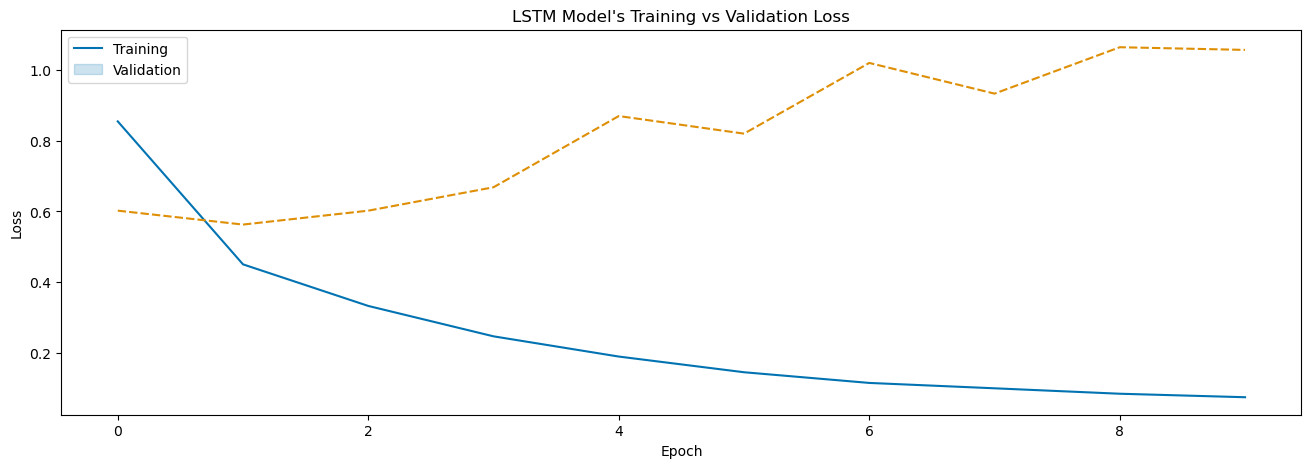

In [313]:
plt.rcParams['figure.figsize'] = [16,5]
# Plot loss
sns.lineplot(data=results[['loss', 'val_loss']])
plt.title('LSTM Model\'s Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show()
plt.rcParams['figure.figsize'] = [16,10]

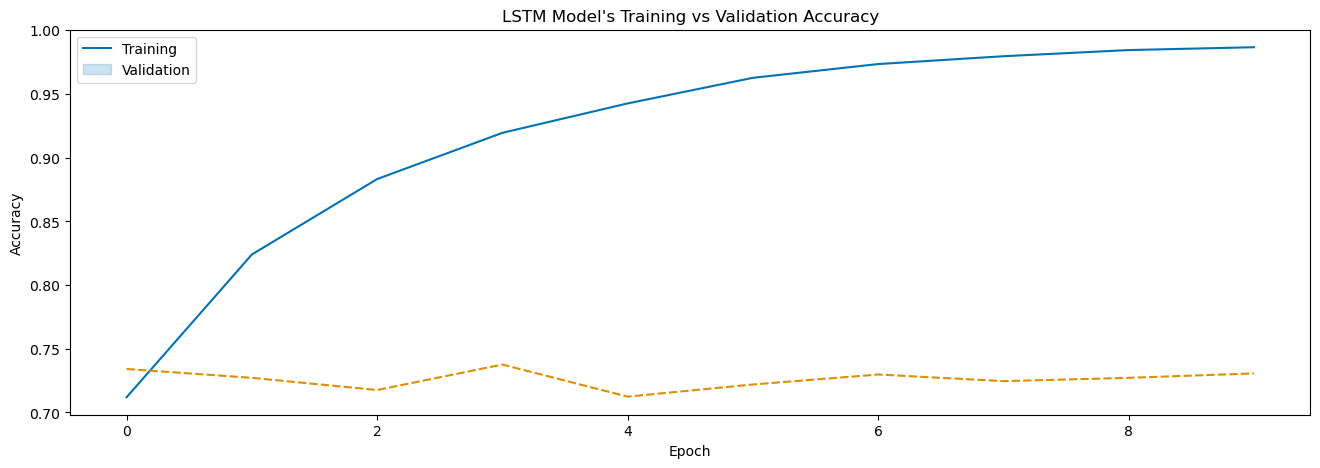

In [314]:
plt.rcParams['figure.figsize'] = [16,5]
#Plot accuracy
sns.lineplot(data=results[['accuracy', 'val_accuracy']])
plt.title('LSTM Model\'s Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()
plt.rcParams['figure.figsize'] = [16,10]

In [321]:
# Evaluate the model on the test data
print('Evaluate on test data')
loaded_model = load_model('model_checkpoint_without_SRL_final.h5')
test_results = loaded_model.evaluate(X_test, y_test, batch_size=32)
print('Test loss, Test accuracy:', test_results)

Evaluate on test data
36/36 [==============================] - 0s 2ms/step - loss: 0.6400 - accuracy: 0.7576
Test loss, Test accuracy: [0.6400271058082581, 0.7576020956039429]


In [322]:
# Save the trained network
#model.save('lstm_model.h5')  # create an HDF5 file 'lstm_model.h5'

In [323]:
y_pred = loaded_model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1 score
report = classification_report(y_true_labels, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.62      0.44      0.51       338
           1       0.79      0.89      0.84       813

    accuracy                           0.76      1151
   macro avg       0.71      0.66      0.68      1151
weighted avg       0.74      0.76      0.74      1151

